In [2]:
pip install sklearn_crfsuite seqeval

In [3]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import KFold
import scipy
import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import cross_validate, cross_val_predict
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score
from sklearn.metrics import make_scorer
import nltk
from nltk import word_tokenize,pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

**Loading the Data**

In [4]:
train_data = {}
test_data = {}
for i in range(1,4):
  with open(f'/content/RQA_train_{i}.json') as f:
    train_data[f'train{i}'] = pd.DataFrame([json.loads(line) for line in f])
  with open(f'/content/RQA_test_{i}.json') as f:
    test_data[f'test{i}'] = pd.DataFrame([json.loads(line) for line in f])


train1 = train_data['train1']
train2 = train_data['train2']
train3 = train_data['train3']
test1 = test_data['test1']
test2 = test_data['test2']
test3 = test_data['test3']

In [5]:
train1.head()

,tokens,labels
0,"[Each, thermostat, should, have, a, unique, id...","[O, B-ACTOR, B-IMPERATIVE, B-ACTION, O, O, O, ..."
1,"[The, maximum, number, of, concurrently, runni...","[O, B-AMBIGUITY, O, O, O, O, O, O, O, O, O, O,..."
2,"[The, maximum, number, of, concurrently, runni...","[O, B-AMBIGUITY, O, O, O, O, O, O, O, O, O, O,..."
3,"[There, shall, be, a, maximum, number, of, hea...","[B-PRONOUN, B-IMPERATIVE, B-ACTION, O, O, O, O..."
4,"[Establish_Valid_Temperature_Range, shall, rea...","[B-ACTION, O, O, O, O, O, O, O, O, O, O, O, O,..."


In [6]:
train2.head()

,tokens,labels
0,"[The, system, shall, read, the, intialization,...","[O, B-ACTOR, B-IMPERATIVE, B-ACTION, O, O, O, ..."
1,"[The, THEMAS, system, shall, use, the, informa...","[O, B-DESIGN_STATEMENTS, B-ACTOR, B-IMPERATIVE..."
2,"[Each, thermostat, shall, have, a, unique, ide...","[O, B-ACTOR, B-IMPERATIVE, B-ACTION, O, O, O, ..."
3,"[The, maximum, number, of, concurrently, runni...","[O, B-AMBIGUITY, O, O, O, O, O, O, O, O, O, O,..."
4,"[The, maximum, number, of, concurrently, runni...","[O, B-AMBIGUITY, O, O, O, O, O, O, O, O, O, O,..."


In [7]:
train3.head()

,tokens,labels
0,"[The, system, shall, read, the, intialization,...","[O, B-ACTOR, B-IMPERATIVE, B-ACTION, O, O, O, ..."
1,"[The, maximum, number, of, concurrently, runni...","[O, B-AMBIGUITY, O, O, O, O, O, O, O, O, O, O,..."
2,"[The, maximum, number, of, concurrently, runni...","[O, B-AMBIGUITY, O, O, O, O, O, O, O, O, O, O,..."
3,"[There, shall, be, a, maximum, number, of, hea...","[B-PRONOUN, B-IMPERATIVE, B-ACTION, O, O, O, O..."
4,"[Establish_Valid_Temperature_Range, shall, rea...","[B-ACTION, O, O, O, O, O, O, O, O, O, O, O, O,..."


In [8]:
def max_length_token(token_collection):
  length = []
  for i in token_collection:
    length.append(len(i))
  return max(length)

In [9]:
print(f'Max_length of token in train1 is : {max_length_token(train1.tokens)}')
print(f'Max_length of token in train2 is : {max_length_token(train2.tokens)}')
print(f'Max_length of token in train3 is : {max_length_token(train3.tokens)}')
print(f'Max_length of token in test1 is : {max_length_token(test1.tokens)}')
print(f'Max_length of token in test2 is : {max_length_token(test2.tokens)}')
print(f'Max_length of token in test3 is : {max_length_token(test3.tokens)}')

Max_length of token in train1 is : 67
Max_length of token in train2 is : 66
Max_length of token in train3 is : 66
Max_length of token in test1 is : 67
Max_length of token in test2 is : 67
Max_length of token in test3 is : 67


In [10]:
def total_labels(labels_collection):
  total_labels = []
  for index,val in enumerate(labels_collection):
    for i in range(len(val)):
      total_labels.append(val[i])
  return set(total_labels),total_labels

In [11]:
labels,total_label = total_labels(train1.labels)
print(f"Labels in dataset are : \n {pd.DataFrame(labels)}")

Labels in dataset are : 
                              0
0     I-SUPERFLUOUS_INFINITIVE
1                B-COMBINATORS
2   I-MAIN_VERB_IN_CONDITIONAL
3           B-VAGUE_QUANTIFIER
4                 B-IMPERATIVE
5                     I-ACTION
6                   I-OPERATOR
7                    I-PASSIVE
8              B-ESCAPE_CLAUSE
9                            O
10                  B-OPERATOR
11                   B-PRONOUN
12                    B-ACTION
13                    B-OBJECT
14                   B-PASSIVE
15                      B-USER
16                 B-TOLERANCE
17         I-QUALIFYING_CLAUSE
18                     I-ACTOR
19                  I-NEGATIVE
20                 B-MAIN_VERB
21                 B-AMBIGUITY
22                    B-CLAUSE
23         B-DESIGN_STATEMENTS
24             I-ESCAPE_CLAUSE
25                  B-NEGATIVE
26    B-SUPERFLUOUS_INFINITIVE
27                 I-TOLERANCE
28         B-QUALIFYING_CLAUSE
29  B-MAIN_VERB_IN_CONDITIONAL
30           

In [12]:
from collections import Counter
counts = Counter(total_label)
print(counts)

Counter({'O': 3813, 'B-ACTION': 201, 'B-IMPERATIVE': 163, 'B-ACTOR': 161, 'B-QUALIFYING_CLAUSE': 111, 'B-CLAUSE': 51, 'B-OBJECT': 37, 'I-SUPERFLUOUS_INFINITIVE': 29, 'B-USER': 27, 'B-PASSIVE': 26, 'B-AMBIGUITY': 23, 'B-SUPERFLUOUS_INFINITIVE': 22, 'I-PASSIVE': 21, 'I-ACTION': 15, 'B-PRONOUN': 14, 'I-ACTOR': 12, 'B-MAIN_VERB_IN_CONDITIONAL': 11, 'B-COMBINATORS': 11, 'B-NEGATIVE': 8, 'I-QUALIFYING_CLAUSE': 6, 'B-VAGUE_QUANTIFIER': 6, 'B-DESIGN_STATEMENTS': 4, 'I-ESCAPE_CLAUSE': 4, 'B-MAIN_VERB': 3, 'B-OPERATOR': 2, 'I-OPERATOR': 2, 'B-TOLERANCE': 2, 'I-NEGATIVE': 2, 'B-ESCAPE_CLAUSE': 2, 'I-TOLERANCE': 1, 'I-MAIN_VERB_IN_CONDITIONAL': 1})


In [13]:
entity = []
frequency = []
for key,value in counts.items():
  entity.append(key)
  frequency.append(value)

In [14]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

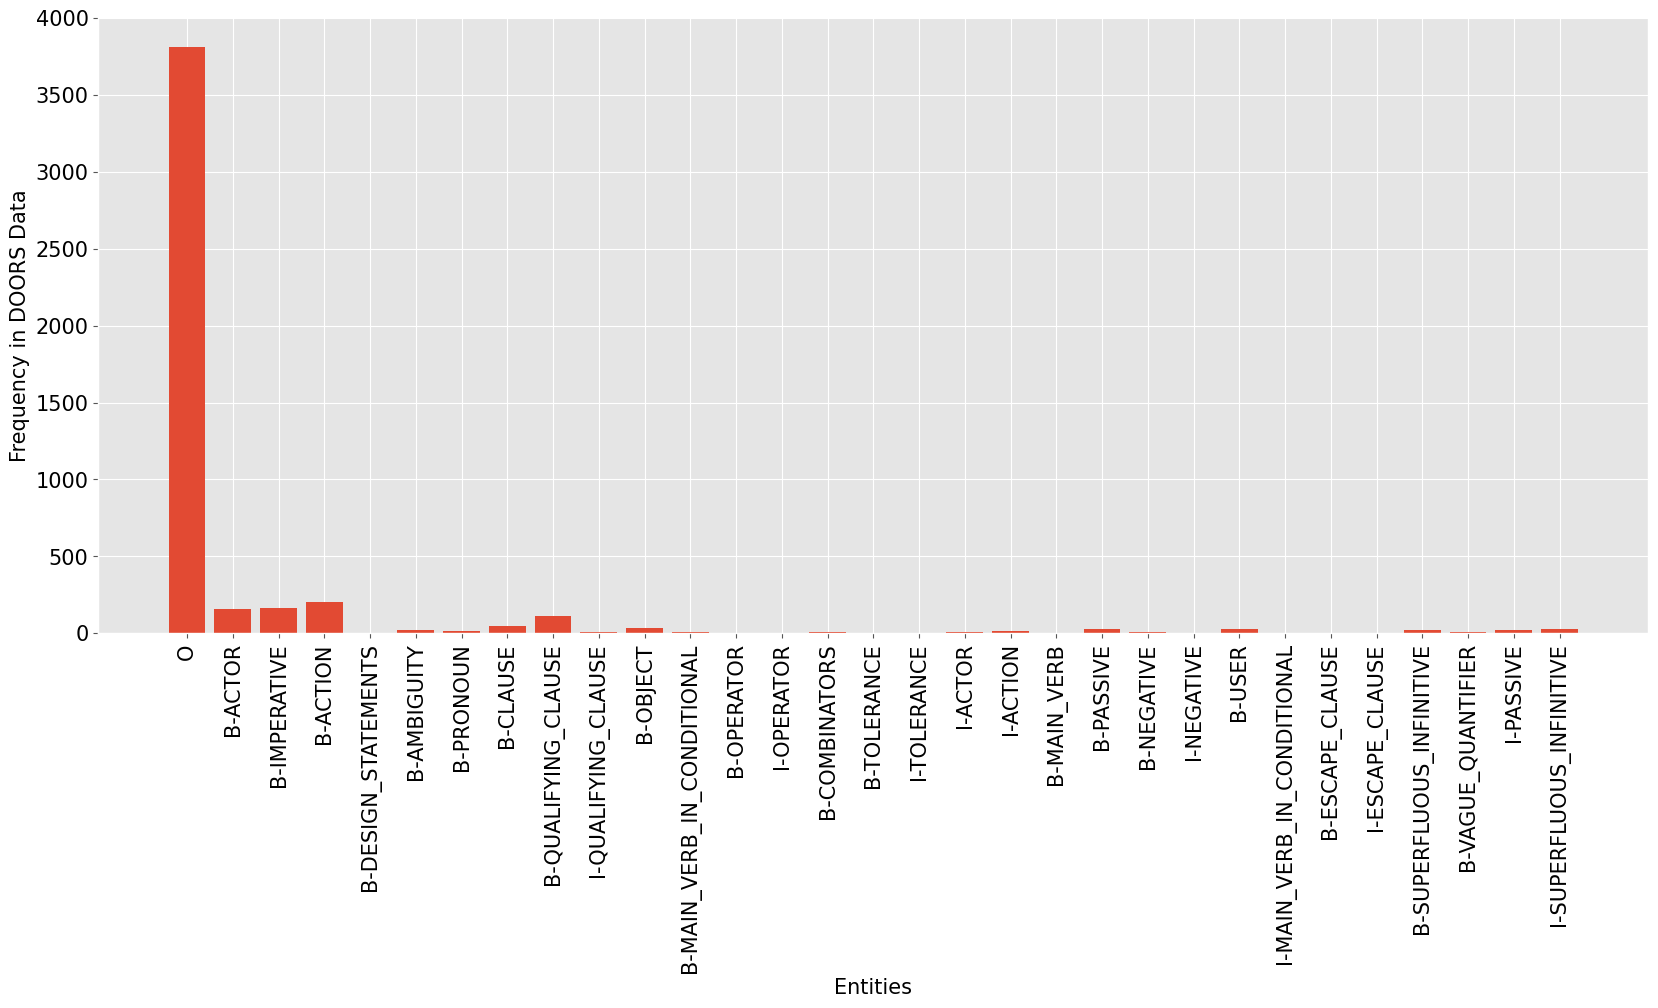

In [15]:
plt.subplots(figsize=(20,8))
plt.bar(entity,frequency)
#plt.title('Token per sentence')
plt.xticks(fontsize=15,color='black',rotation=90)
plt.yticks(fontsize=15,color='black')
plt.xlabel('Entities',fontsize=15,color='black')
plt.ylabel('Frequency in DOORS Data',fontsize = 15,color='black')
plt.savefig('doors_dist.pdf',)
plt.show()

In [16]:
## merging sentence and labels

In [17]:
def merge(list1, list2):
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

def merge_tokens_labels(tokens,labels):
  sentences_train = []
  for i in range(len(tokens)):
    sentences_train.append(merge(tokens[i],labels[i]))
  return sentences_train


train_set = [train1,train2,train3]
test_set = [test1,test2,test3]
for i in range(3):
  print(f'Number of sentences in train{i+1} is : {len(merge_tokens_labels(train_set[i].tokens,train_set[i].labels))}')
  print(f'Number of sentences in test{i+1} is : {len(merge_tokens_labels(test_set[i].tokens,test_set[i].labels))}')


Number of sentences in train1 is : 253
Number of sentences in test1 is : 126
Number of sentences in train2 is : 252
Number of sentences in test2 is : 126
Number of sentences in train3 is : 252
Number of sentences in test3 is : 126


# Converting data to model input format

In [18]:
## TAKING TRAIN1 DATA FOR MODEL TRAINING

In [35]:
sentences_train = merge_tokens_labels(train2.tokens,train2.labels)
sentences_test = merge_tokens_labels(test2.tokens,test2.labels)

In [36]:
sentences_train[0]

[('The', 'O'),
 ('system', 'B-ACTOR'),
 ('shall', 'B-IMPERATIVE'),
 ('read', 'B-ACTION'),
 ('the', 'O'),
 ('intialization', 'O'),
 ('file', 'O'),
 ('and', 'O'),
 ('the', 'O'),
 ('definitions', 'O'),
 ('shall', 'O'),
 ('be', 'O'),
 ('derived', 'O'),
 ('from', 'O'),
 ('the', 'O'),
 ('initialization', 'O'),
 ('data', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('file.', 'O')]

In [69]:
def data_tagged(sentences):
  data = []
  for i, doc in enumerate(sentences):
      tokens = [t for t, label in doc]
      tagged = nltk.pos_tag(tokens)
      data.append([(w, pos, label) for (w, label), (word, pos) in zip(doc, tagged)])
  return data

data_train = data_tagged(sentences_train)
data_test = data_tagged(sentences_test)

In [70]:
print(len(data_train),len(data_test))

252 126


In [56]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, pos,label in sent]

def sent2tokens(sent):
    return [token for token,pos, label in sent]

In [71]:
X_train = [sent2features(s) for s in data_train]
y_train = [sent2labels(s) for s in data_train]
X_test = [sent2features(s) for s in data_test]
y_test = [sent2labels(s) for s in data_test]

In [72]:
X_train[0],y_train[0]

([{'bias': 1.0,
   'word.lower()': 'the',
   'word[-3:]': 'The',
   'word[-2:]': 'he',
   'word.isupper()': False,
   'word.istitle()': True,
   'word.isdigit()': False,
   'postag': 'DT',
   'postag[:2]': 'DT',
   'BOS': True,
   '+1:word.lower()': 'system',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:postag': 'NN',
   '+1:postag[:2]': 'NN'},
  {'bias': 1.0,
   'word.lower()': 'system',
   'word[-3:]': 'tem',
   'word[-2:]': 'em',
   'word.isupper()': False,
   'word.istitle()': False,
   'word.isdigit()': False,
   'postag': 'NN',
   'postag[:2]': 'NN',
   '-1:word.lower()': 'the',
   '-1:word.istitle()': True,
   '-1:word.isupper()': False,
   '-1:postag': 'DT',
   '-1:postag[:2]': 'DT',
   '+1:word.lower()': 'shall',
   '+1:word.istitle()': False,
   '+1:word.isupper()': False,
   '+1:postag': 'MD',
   '+1:postag[:2]': 'MD'},
  {'bias': 1.0,
   'word.lower()': 'shall',
   'word[-3:]': 'all',
   'word[-2:]': 'll',
   'word.isupper()': False,
   'word.istitle

# **Model Training**

In [59]:
## Hyperparmeter Tuning using crf

In [60]:
# crf = CRF(
#     algorithm='lbfgs',
#     max_iterations=100,
#     all_possible_transitions=True
# )
# params_space = {
#     'c1': scipy.stats.expon(scale=0.5),
#     'c2': scipy.stats.expon(scale=0.05),
# }

# # use the same metric for evaluation
# f1_scorer = make_scorer(flat_f1_score,
#                         average='macro')

# # search
# rs = RandomizedSearchCV(crf, params_space,
#                         cv=3,
#                         verbose=1,
#                         n_jobs=-1,
#                         n_iter=50,
#                         scoring=f1_scorer)
# rs.fit(X,y)

In [61]:
# print('best params:', rs.best_params_)
# print('best CV score:', rs.best_score_)
# print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [62]:
import pickle

In [73]:
crf = CRF(algorithm = 'lbfgs',   ## using the best parameters
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    max_iterations=100)

In [101]:
filename = 'ml_crf_ner.sav'
pickle.dump(crf, open(filename, 'wb'))

In [74]:
y_pred = crf.predict(X_test)

In [75]:
tags = list(labels)
tag2idx = {t: i for i, t in enumerate(tags)}


In [76]:
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

                  ACTION       0.84      0.80      0.82        98
                   ACTOR       0.86      0.84      0.85        77
               AMBIGUITY       0.67      0.60      0.63        10
                  CLAUSE       0.97      0.97      0.97        31
             COMBINATORS       0.50      0.22      0.31         9
       DESIGN_STATEMENTS       1.00      1.00      1.00         5
           ESCAPE_CLAUSE       1.00      1.00      1.00         1
              IMPERATIVE       0.91      0.86      0.88        84
               MAIN_VERB       1.00      0.25      0.40         4
MAIN_VERB_IN_CONDITIONAL       0.00      0.00      0.00         5
                NEGATIVE       0.50      0.50      0.50         2
                  OBJECT       0.70      0.40      0.51        35
                OPERATOR       0.67      1.00      0.80         2
                 PASSIVE       0.86      0.30      0.44        20
         

In [ ]:
## Kfold cross validation

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
new_crf = CRF(algorithm = 'lbfgs',   ## using the best parameters
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)

In [81]:
f1_weighted = []
f1_macro = []
precision = []
recall = []
kfold_report = []
acc = []
best_svr = new_crf
i = 0
train_data = [train1,train2,train3]
test_data = [test1,test2,test3]
for i in range(3):
    print(f"entering into the fold : {i}")
    sentences_train = merge_tokens_labels(train_data[i].tokens,train_data[i].labels)
    sentences_test = merge_tokens_labels(test_data[i].tokens,test_data[i].labels)
    data_train = data_tagged(sentences_train)
    data_test = data_tagged(sentences_test)
    X_train = [sent2features(s) for s in data_train]
    y_train = [sent2labels(s) for s in data_train]
    X_test = [sent2features(s) for s in data_test]
    y_test = [sent2labels(s) for s in data_test]
    best_svr.fit(X_train, y_train)
    y_pred = best_svr.predict(X_test)
    kfold_report.append(classification_report(y_test,y_pred,output_dict=True))
    print(classification_report(y_test,y_pred))
    f1_macro.append(f1_score(y_test, y_pred, average = 'macro'))
    f1_weighted.append(f1_score(y_test,y_pred, average='weighted'))
    precision.append(precision_score(y_test,y_pred,average='weighted'))
    recall.append(recall_score(y_test,y_pred,average='weighted'))
    acc.append(accuracy_score(y_test,y_pred))
    print("Accuracy :",accuracy_score(y_test,y_pred))
    print("F1_macro : ",f1_score(y_test, y_pred, average = 'macro'))
    print("F1_weighted : ",f1_score(y_test, y_pred, average = 'weighted'))
    print("Precision : ",precision_score(y_test,y_pred,average='weighted'))
    print ("Recall : ",recall_score(y_test,y_pred,average='weighted'))
    i = i+1


entering into the fold : 0
                          precision    recall  f1-score   support

                  ACTION       0.81      0.78      0.79        98
                   ACTOR       0.81      0.78      0.79        77
               AMBIGUITY       0.70      0.70      0.70        10
                  CLAUSE       0.97      1.00      0.98        28
             COMBINATORS       0.33      0.12      0.18         8
       DESIGN_STATEMENTS       1.00      0.38      0.55         8
           ESCAPE_CLAUSE       1.00      1.00      1.00         1
              IMPERATIVE       0.89      0.89      0.89        75
               MAIN_VERB       0.00      0.00      0.00         1
MAIN_VERB_IN_CONDITIONAL       0.50      0.50      0.50         4
                NEGATIVE       0.67      0.67      0.67         3
                  OBJECT       0.56      0.35      0.43        26
                OPERATOR       0.00      0.00      0.00         1
                 PASSIVE       0.67      0.46   

In [82]:
kfold_report[0].keys()

dict_keys(['ACTION', 'ACTOR', 'AMBIGUITY', 'CLAUSE', 'COMBINATORS', 'DESIGN_STATEMENTS', 'ESCAPE_CLAUSE', 'IMPERATIVE', 'MAIN_VERB', 'MAIN_VERB_IN_CONDITIONAL', 'NEGATIVE', 'OBJECT', 'OPERATOR', 'PASSIVE', 'PRONOUN', 'QUALIFYING_CLAUSE', 'SUPERFLUOUS_INFINITIVE', 'TOLERANCE', 'USER', 'VAGUE_QUANTIFIER', 'micro avg', 'macro avg', 'weighted avg'])

In [83]:
print("the summary of f1 scores : ", np.mean(acc),np.mean(f1_macro),np.mean(f1_weighted),np.mean(precision),np.mean(recall))

the summary of f1 scores :  0.9105101024499208 0.5952616902761374 0.7485255141002559 0.8075168039552084 0.7123298763282874


In [84]:
print("Standard Deviation of f1 scores : ", np.std(acc), np.std(f1_macro),np.std(f1_weighted),np.std(precision),np.std(recall))

Standard Deviation of f1 scores :  0.005452145905501078 0.01682673855105651 0.0031163105842081 0.026617749665798215 0.009457353020864678


In [85]:
full_report = kfold_report
class_label = list(kfold_report[0].keys())
df_final = pd.DataFrame(columns=['class_label', 'Precision_mean',"Precision_std", 'Recall_mean', 'Recall_std',
                           'F1-score_mean','F1-score_std','support_mean'],index = range(0,4))
for index, i in enumerate(class_label):
  p = []
  r = []
  f = []
  s = []
  for j in range(3):
    p.append(full_report[j][i]['precision'])
    r.append(full_report[j][i]['recall'])
    f.append(full_report[j][i]['f1-score'])
    s.append(full_report[j][i]['support'])
  row = [i,np.mean(p).round(4),np.std(p).round(4),np.mean(r).round(4),np.std(r).round(4),np.mean(f).round(4),np.std(f).round(4),np.mean(s).round(4)]
  df_final.loc[index] = row

In [86]:
df_final

,class_label,Precision_mean,Precision_std,Recall_mean,Recall_std,F1-score_mean,F1-score_std,support_mean
0,ACTION,0.8075,0.0259,0.7538,0.0459,0.7795,0.0364,98.6667
1,ACTOR,0.843,0.023,0.7972,0.0335,0.8191,0.0229,78.6667
2,AMBIGUITY,0.65,0.0491,0.6926,0.0728,0.6661,0.0279,9.6667
3,CLAUSE,0.95,0.0236,0.9892,0.0152,0.9689,0.0106,27.0
4,COMBINATORS,0.4778,0.11,0.2269,0.0851,0.306,0.1007,8.6667
5,DESIGN_STATEMENTS,1.0,0.0,0.744,0.2674,0.8228,0.1986,6.6667
6,ESCAPE_CLAUSE,1.0,0.0,1.0,0.0,1.0,0.0,1.0
7,IMPERATIVE,0.8944,0.0135,0.851,0.0374,0.8718,0.0238,80.0
8,MAIN_VERB,0.6667,0.4714,0.1667,0.1179,0.2667,0.1886,3.0
9,MAIN_VERB_IN_CONDITIONAL,0.1667,0.2357,0.1667,0.2357,0.1667,0.2357,4.0
